<p style="text-align: center;">
    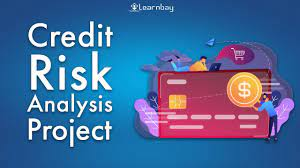
</p>

**Context of the Problem**

One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)

Credit scoring is perhaps one of the most "classic" applications for predictive modeling, to predict whether or not credit extended to an applicant will likely result in profit or losses for the lending institution. There are many variations and complexities regarding how exactly credit is extended to individuals, businesses, and other organizations for various purposes (purchasing equipment, real estate, consumer items, and so on), and using various methods of credit (credit card, loan, delayed payment plan). But in all cases, a lender provides money to an individual or institution, and expects to be paid back in time with interest commensurate with the risk of default. Credit scoring is the set of decision models and their underlying techniques that aid lenders in the granting of consumer credit. These techniques determine who will get credit, how much credit they should get, and what operational strategies will enhance the profitability of the borrowers to the lenders. Further, they help to assess the risk in lending. Credit scoring is a dependable assessment of a person’s credit worthiness since it is based on actual data.

A lender commonly makes two types of decisions: first, whether to grant credit to a new applicant, and second, how to deal with existing applicants, including whether to increase their credit limits. In both cases, whatever the techniques used, it is critical that there is a large sample of previous customers with their application details, behavioral patterns, and subsequent credit history available. Most of the techniques use this sample to identify the connection between the characteristics of the consumers (annual income, age, number of years in employment with their current employer, etc.) and their subsequent history.

Typical application areas in the consumer market include: credit cards, auto loans, home mortgages, home equity loans, mail catalog orders, and a wide variety of personal loan products.



The dataset contains the following columns:

1. **age**: Age of the individual.
2. **ed**: Education level.
3. **employ**: Years of employment.
4. **address**: Years at the current address.
5. **income**: Annual income.
6. **debtinc**: Debt-to-income ratio.
7. **creddebt**: Credit card debt.
8. **othdebt**: Other debts.
9. **default**: Indicates if the individual has defaulted on a loan (1 for default, 0 for no default).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)
from pandas_profiling import profile_report
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from patsy import dmatrices

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/kaggle/input/bankloans/bankloans.csv')

# Data Preprocessing

Data preprocessing is a critical step in the data analysis pipeline, involving the transformation of raw data into a format that is suitable for further analysis. The structure of data preprocessing can vary depending on the specific needs of your project, but it typically includes the following steps:


1. **Data Cleaning**:
   - Handling missing values by Using Predictive Modeling `LogisticRegression`.
   - Identifying and correcting errors or inaccuracies in the data.
   - Removing duplicate records.
   - Detect Outliers and Capturing them
   - **Handle Imbalanced Data using Resampling** the minority class in `default`: Creating additional samples for the minority class Using `SMOTE Method`.

2. **Data Transformation**:
   - Normalization: Scaling numerical data to a standard range.
   - Standardization: Transforming data to have a mean of zero and a standard deviation of one.

3. **Feature Engineering**:
   - Creating new features from the existing data to improve the performance of machine learning models.
   - Use Dimensionality Reduction techniques Such as:
       - Feature Selection
       - Feature Extraction: Includes interaction terms, polynomial features, and aggregations.

In [ ]:
# Generate the profile report
profile = df.profile_report(title='Bank Loans Data Report')

# Save the report to an HTML file
profile.to_file('bankloans_report.html')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

## **Data Cleaning**

#### Step 1: Define Predictor Variables
Define the predictor variables (features) to be used in the model. In this case, we are using age, education, employment, address, income, debt-to-income ratio, credit debt, and other debts.

#### Step 2: Split Dataset for Missing Target Imputation

Split the dataset into two subsets: 
- A subset with non-missing target values (`subset_with_target`).
- A subset with missing target values (`subset_missing_target`).

#### Step 3: Train/Test Split for Imputation Model

Perform a train/test split on the subset with the target variable. This split is used for training and evaluating the logistic regression model for imputation.

#### Step 4: Logistic Regression for Imputation

Train a logistic regression model on the training set to predict the missing target values.

#### Step 5: Impute Missing Target Values

Use the trained logistic regression model to predict and impute the missing target values in `subset_missing_target`.

#### Step 6: Combine Imputed Data

Combine the subset with imputed values and the subset with original target values into a single DataFrame, `df_imputed`.

#### Step 7: Evaluate Imputation Model Performance

Evaluate the accuracy of the imputation model using the test set.

#### Step 8: Data Preparation for Machine Learning

Prepare the data for machine learning by separating features (X) and the target variable (y) after imputation.

#### Step 9: Apply SMOTE for Class Balancing

Use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the target variable.

#### Step 10: Check Class Distribution After Oversampling

Check the distribution of classes in the target variable after applying SMOTE.

#### Step 11: Create Combined DataFrame

Create a new DataFrame, `df_combined`, that includes both the imputed values and the oversampled data.

This structure provides a clear, step-by-step breakdown of the preprocessing and modeling steps, ideal for documentation or educational purposes in a Markdown format.

In [ ]:
# Define the predictor variables (features)
predictor_columns = ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt']  # Replace with your actual feature names

# Split the dataset into two subsets: one with non-missing target values and one with missing target values
subset_with_target = df[df['default'].notna()]
subset_missing_target = df[df['default'].isna()]

# Split the subset_with_target into train and test sets for model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(
    subset_with_target[predictor_columns],
    subset_with_target['default'],
    test_size=0.2,
    random_state=42
)

# Train a logistic regression model for imputation
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the missing target values in subset_missing_target
missing_target_predictions = model.predict(subset_missing_target[predictor_columns])

# Impute the missing target values with the predicted values
subset_missing_target['default'] = missing_target_predictions

# Combine the two subsets back into the original dataset
df_imputed = pd.concat([subset_with_target, subset_missing_target])

# Evaluate the performance of the imputation model
imputation_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Imputation Model Accuracy: {imputation_accuracy:.2f}")

# Separate the features (X) and the target variable (y) after imputation
X = df_imputed.drop('default', axis=1)
y = df_imputed['default']

# Apply SMOTE to balance the target variable
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after oversampling
class_distribution_after = y_resampled.value_counts()
print("\nClass distribution after oversampling:")
print(class_distribution_after)

# Create a new DataFrame with imputed values and oversampled data
df_combined = pd.DataFrame(X_resampled, columns=X.columns)
df_combined['default'] = y_resampled

Now df_combined contains the combined results with imputed values and oversampled data


In [ ]:
# Check Balanced Status
df_combined['default'].value_counts()

In [ ]:
# Check Duplicated Rows in our Data
df_combined.duplicated().sum()

## Outlier Detection and Explanation

Here's a brief analysis of potential outliers, based on the box plots:

1. **Age**: There appear to be no significant outliers in both default groups.
2. **Education (ed)**: Some high education levels are outliers in both default groups.
3. **Employment (employ)**: A few cases with exceptionally high employment years, especially in the non-default group.
4. **Address**: Similar to employment, a few high values, more pronounced in the non-default group.
5. **Income**: Notable outliers with very high incomes, especially in the non-default group.
6. **Debt-to-Income Ratio (debtinc)**: Outliers present with very high ratios in both groups.
7. **Credit Debt (creddebt) and Other Debt (othdebt)**: Both have outliers with very high debt amounts in both default groups.

In [ ]:
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in df_combined.columns:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = df_combined)
    bp.savefig(fig)
bp.close()

## Deal with Outliers
**First**: Make IQR and Log_transform Functions to deal with each Feature in Our Data

In [ ]:
# Function to cap outliers using the IQR method
def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower_bound, upper_bound)

# Function for log transformation
def log_transform(series):
    return np.log(series + 1)  # Adding 1 to avoid log(0)

Apply Changes to each feature that have Outliers

In [ ]:
# Employment (employ) and Address: Cap outliers
df_combined['employ'] = cap_outliers_iqr(df_combined['employ'])
df_combined['address'] = cap_outliers_iqr(df_combined['address'])

# Income: Apply log transformation
df_combined['income'] = log_transform(df_combined['income'])

# Debt-to-Income Ratio (debtinc): Apply log transformation
df_combined['debtinc'] = log_transform(df_combined['debtinc'])

# Credit Debt (creddebt) and Other Debt (othdebt): Apply log transformation
df_combined['creddebt'] = log_transform(df_combined['creddebt'])
df_combined['othdebt'] = log_transform(df_combined['othdebt'])

In [ ]:
df_combined.info()

---
# Data Visualization

### 1. Histogram of Ages

In [ ]:
# Histogram of Ages
hist_age = px.histogram(df_combined, x='age', title='Age Distribution')
hist_age.show()

### 2. Histogram of creddebt

In [ ]:
hist_age = px.histogram(df_combined, x='creddebt', title='Cred Debt Distribution')
hist_age.show()

### 3. Box Plot for Income by Default Status

In [ ]:
# Box plot for Income by Default Status
box_income = px.box(df_combined, x='default', y='income', 
                    labels={"default": "Default Status", "income": "Income"},
                    title='Income Distribution by Default Status')
box_income.show()

### 4. Scatter Plot of Income vs. Debt-to-Income Ratio
### In another Way of Analysis: What is the relationship between income and credit card debt?
This question examines if higher income individuals tend to have more credit card debt.



In [ ]:
# Scatter plot of Income vs. Debt-to-Income Ratio
scatter_debt_income = px.scatter(df_combined, x='income', y='debtinc', color='default', 
                                 labels={"income": "Income", "debtinc": "Debt-to-Income Ratio"},
                                 title='Income vs. Debt-to-Income Ratio by Default Status')
scatter_debt_income.show()

### 5. Bar Plot for Average Income by Education Level

In [ ]:
# Bar plot for Average Income by Education Level
bar_edu_income = px.bar(df_combined.groupby('ed')['income'].mean().reset_index(), 
                        x='ed', y='income', 
                        labels={"ed": "Education Level", "income": "Average Income"},
                        title='Average Income by Education Level')
bar_edu_income.show()

### 6. Pie Chart Showing the Proportion of Default vs. Non-Default Cases

In [ ]:
# Pie chart for Proportion of Default vs Non-Default Cases
pie_default = px.pie(df_combined, names='default', 
                     title='Proportion of Default vs Non-Default Cases',
                     labels={"default": "Default Status"})
pie_default.show()

In [ ]:
# Pie chart for Proportion of Default vs Non-Default Cases
pie_default = px.pie(df_combined, names='ed', 
                     title='Proportion of Education Level',
                     labels={"ed": "Education Level"})
pie_default.show()

In [ ]:
# Line plot for Average Debt-to-Income Ratio by Years of Employment
line_emp_debtinc = px.line(df_combined.groupby('employ')['debtinc'].mean().reset_index(), 
                           x='employ', y='debtinc', 
                           labels={"employ": "Years of Employment", "debtinc": "Average Debt-to-Income Ratio"},
                           title='Average Debt-to-Income Ratio by Years of Employment')
line_emp_debtinc.show()


# Data Analysis

### 1. What is the average age of individuals who have defaulted on a loan versus those who have not?

This question aims to understand if there's a noticeable age difference between those who default and those who don't.

In [ ]:
# 1. Average age of individuals who have defaulted vs. those who have not
avg_age_default = df_combined.groupby('default')['age'].mean()
print("Average Age by Default Status", avg_age_default)

**Average Age of Individuals Who Have Defaulted vs. Those Who Have Not**:
   - Non-defaulters: Average age is approximately 34.3 years.
   - Defaulters: Average age is approximately 31.4 years.
   This suggests that younger individuals are slightly more likely to default.

### 2. Is there a correlation between the level of education and the likelihood of defaulting on a loan?
This explores if education level impacts loan defaulting.

In [ ]:
# 2. Correlation between education level and defaulting
default_rate_by_edu = df_combined.groupby('ed')['default'].mean()
print("Default Rate by Education Level", default_rate_by_edu)

**Correlation Between Education Level and Defaulting**:
   - Education Level 1: 21.2% default rate.
   - Education Level 2: 29.8% default rate.
   - Education Level 3: 34.5% default rate.
   Higher education levels (2 and 3) have a higher default rate, except for level 1, which has a lower default rate, though this could be due to a smaller sample size for level 1.

### 3. How does the length of employment affect the debt-to-income ratio?
Investigates if longer employment correlates with a better or worse debt-to-income ratio.

In [ ]:
# 3. Relationship between length of employment and debt-to-income ratio
avg_debtinc_by_employ = df_combined.groupby('employ')['debtinc'].mean()
print("Average Debt-to-Income Ratio by Employment Years", avg_debtinc_by_employ)

**Average Debt-to-Income Ratio by Employment Years**:
   - The debt-to-income ratio varies with years of employment, peaking at around 10-15 years of employment and generally decreasing afterwards. This suggests that individuals in mid-career stages might have higher debt burdens relative to their income.

### 4. Are individuals with higher debts more likely to default?
A key question for risk assessment in lending.

In [ ]:
# 4. Average debts of individuals who default vs. those who do not
avg_debts_by_default_status = df_combined.groupby('default')[['creddebt', 'othdebt']].mean()
print("Average Debts by Default Status\n", avg_debts_by_default_status)

**Average Debts of Individuals Who Default vs. Those Who Do Not**:
- **Non-defaulters**:
  - Average credit card debt: Approximately 0.90
  - Average other debts: Approximately 2.05

- **Defaulters**:
  - Average credit card debt: Approximately 1.34
  - Average other debts: Approximately 2.61

---
# Feature Engineering
here are some feature engineering steps we could consider:

1. **Binning Age**: Group ages into categories such as 'Young', 'Middle-Aged', 'Senior'. This can sometimes help models capture nonlinear relationships better.

2. **Log Transformation**: Apply log transformation to skewed data like income, creddebt, and othdebt to normalize their distribution. Many models work better with normally distributed data.

3. **Interaction Terms**: Create interaction terms that are combinations of existing features, such as `income * debtinc` to represent the interaction between income and debt-to-income ratio.

4. **One-Hot Encoding for Education Level**: Convert the education level (ed) into dummy variables for each level of education. This is necessary since most machine learning models require numerical input.

5. **Standardizing or Normalizing Data**: Standardize (or normalize) features like income, debtinc, etc., to have a mean of 0 and a standard deviation of 1 (or to range between 0 and 1). This is particularly important for algorithms that are sensitive to the scale of the data, like SVM or k-NN.

6. **Default History**: If you have historical data, creating a feature that counts the number of previous defaults can be useful.

7. **Debt Ratios**: Create new features like the ratio of creddebt to income or othdebt to income, providing a more nuanced view of debt relative to income.

8. **Employment Stability**: A feature that combines years of employment and years at the current address could indicate overall stability, which might be predictive of loan repayment.


In [ ]:
# Copy the original dataset
data_fe = df_combined.copy()

# 1. Binning Age
bins = [0, 25, 40, 60, 100]
labels = ['Young', 'Young Adult', 'Middle-Aged', 'Senior']
data_fe['age_bin'] = pd.cut(data_fe['age'], bins=bins, labels=labels)

# 2. Log Transformation
for col in ['income', 'creddebt', 'othdebt']:
    data_fe[col + '_log'] = np.log(data_fe[col] + 1)  # Adding 1 to avoid log(0)

# 3. Interaction Terms
data_fe['income_debtinc_interaction'] = data_fe['income'] * data_fe['debtinc']

# 4. One-Hot Encoding for Education Level
edu_dummies = pd.get_dummies(data_fe['ed'], prefix='ed')
data_fe = pd.concat([data_fe, edu_dummies], axis=1)

# 5. Standardizing Data
scaler = StandardScaler()
scaled_cols = ['income', 'debtinc', 'creddebt', 'othdebt']
data_fe[scaled_cols] = scaler.fit_transform(data_fe[scaled_cols])

# 6. Debt Ratios
data_fe['creddebt_income_ratio'] = data_fe['creddebt'] / data_fe['income']
data_fe['othdebt_income_ratio'] = data_fe['othdebt'] / data_fe['income']

# Show the first few rows of the modified dataset
data_fe.head()

The dataset has been enhanced with several new features, making it more suitable for machine learning analysis:

1. **Age Binned**: Ages have been categorized into 'Young', 'Young Adult', 'Middle-Aged', and 'Senior'.

2. **Log Transformation**: Applied to 'income', 'creddebt', and 'othdebt' to reduce skewness.

3. **Interaction Term**: Created between 'income' and 'debtinc', capturing their combined effect.

4. **One-Hot Encoding for Education**: 'ed' is transformed into dummy variables for each education level.

5. **Standardization**: 'income', 'debtinc', 'creddebt', and 'othdebt' have been scaled.

6. **Debt Ratios**: New features 'creddebt_income_ratio' and 'othdebt_income_ratio' show debts relative to income.

In [ ]:
data_fe.info()

# **Machine Learning Baseline**

#### **Step 1:** Data Preparation

Prepare the dataset for machine learning. This involves selecting the features (X) and the target variable (y). Assume `data_fe` is the dataset with feature engineering already applied.

In [ ]:
# ['age', 'ed', 'age_bin', 'default']
X = data_fe.drop('default', axis=1)
y = data_fe['default']

#### **Step 2:** Train/Test Split

Split the dataset into training and testing sets. This is crucial for training the model and for an unbiased evaluation of its performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Step 4**: Create XGBoost Classifier

In [ ]:
xgb_classifier = xgb.XGBClassifier(random_state=42, enable_categorical=True)

#### **Step 5:** Train the Classifier

In [ ]:
xgb_classifier.fit(X_train, y_train)

#### **Step 6:** Make Predictions and Evaluate the Model
Evaluate the model's performance using the confusion matrix and classification report. These metrics provide insights into the accuracy, precision, recall, and F1-score of the model.

In [ ]:
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary') # Change 'binary' to 'macro' or 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='binary') # Change 'binary' to 'macro' or 'weighted' for multi-class
f1 = f1_score(y_test, y_pred, average='binary') # Change 'binary' to 'macro' or 'weighted' for multi-class

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

print(classification_report(y_test, y_pred))

# **Model Improvement**

#### **Step 1**: Define Parameter Grid
Specify the range of hyperparameters to test. Here's an example grid:


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

#### **Step 2**: Configure Grid Search CV
Instantiate GridSearchCV with the Random Forest Classifier, parameter grid, and the number of folds for cross-validation. For example, using 5-fold cross-validation:

In [ ]:
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

#### **Step 3:** Fit Grid Search to Data
Use the training data for this step.



In [ ]:
grid_search.fit(X_train, y_train)

#### **Step 4:** View Best Parameters
After fitting, you can find the best parameters from the grid search.


In [ ]:
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

#### **Step 5:** Evaluate the Best Model
Use the best estimator to make predictions and evaluate its performance.

In [ ]:
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))

# Author: Abdelrahman Ashour